# SPEI at Bloomington site

In [59]:
# Data are from Jenn Rudgers for NOAA site near Bloomington
# https://drive.google.com/file/d/0B3oF4kdw3iW3X3RmcE80WWIyZGs/view?usp=sharing

fname <- 'spei_input_files/NOAA_Bloomington.csv'
lat <- 39.162222 # Latitude of the station (bloomington IN coordinate)

# Get spei tools
source('~/current/climate_tools/spei.r')

df <- read.csv(fname, skip=0, header=TRUE)
colnames(df)
head(df)

[1] "Sta"                   "STATION_NAME"          "ELEVATION"            
 [4] "LATITUDE"              "LONGITUDE"             "water_year"           
 [7] "Year"                  "Month"                 "Day"                  
[10] "DATE"                  "PRCP"                  "Measurement_Flag"     
[13] "Quality_Flag"          "Source_Flag"           "Time_of_Observation"  
[16] "SNWD"                  "Measurement_Flag.1"    "Quality_Flag.1"       
[19] "Source_Flag.1"         "Time_of_Observation.1" "SNOW"                 
[22] "Measurement_Flag.2"    "Quality_Flag.2"        "Source_Flag.2"        
[25] "Time_of_Observation.2" "TAVG"                  "TMAX"                 
[28] "Measurement_Flag.3"    "Quality_Flag.3"        "Source_Flag.3"        
[31] "Time_of_Observation.3" "TMIN"                  "Measurement_Flag.4"   
[34] "Quality_Flag.4"        "Source_Flag.4"         "Time_of_Observation.4"
[37] "TOBS"

Sta,STATION_NAME,ELEVATION,LATITUDE,LONGITUDE,water_year,Year,Month,Day,DATE,⋯,Measurement_Flag.3,Quality_Flag.3,Source_Flag.3,Time_of_Observation.3,TMIN,Measurement_Flag.4,Quality_Flag.4,Source_Flag.4,Time_of_Observation.4,TOBS
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,15,18951115,⋯,NA,,6,NA,3.3,NA,,6,NA,NA
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,16,18951116,⋯,NA,,6,NA,0.6,NA,,6,NA,NA
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,17,18951117,⋯,NA,,6,NA,1.7,NA,,6,NA,NA
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,18,18951118,⋯,NA,,6,NA,3.9,NA,,6,NA,NA
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,19,18951119,⋯,NA,,6,NA,3.3,NA,,6,NA,NA
USC00120784,BLOOMINGTON INDIANA UNIVERSITY IN US,NA,NA,NA,1896,1895,11,20,18951120,⋯,NA,,6,NA,-3.9,NA,,6,NA,NA


In [60]:

dateidx <- as.Date(paste(df$Day, '/', df$Month, '/', df$Year, sep=''),  "%d/%m/%Y")
head(dateidx)
prec <- xts(df$PRCP, order.by=dateidx)
tmean_c <- xts(df$TAVG, order.by=dateidx)

[1] "1895-11-15" "1895-11-16" "1895-11-17" "1895-11-18" "1895-11-19"
[6] "1895-11-20"

In [61]:
# Convert to monthly values
prec_m <- apply.monthly(prec, FUN=sum, na.rm=TRUE)
tmean_c_m <- apply.monthly(tmean_c, FUN=mean, na.rm=TRUE)
head(prec_m)
head(tmean_c_m)

            [,1]
1895-11-30 104.4
1895-12-31  88.2
1896-02-29  66.0
1896-03-31  53.4
1896-04-30   0.0
1896-05-31 130.0

                [,1]
1895-11-30  4.443750
1895-12-31       NaN
1896-02-29  2.124138
1896-03-31  3.822581
1896-04-30 16.411667
1896-05-31 21.300000

In [62]:
# Remove months that are end up as nans
test <- is.na(tmean_c_m)
tmean_c_m_nonan <- tmean_c_m[!test]
prec_m_nonan <- prec_m[!test]
head(tmean_c_m_nonan)
head(prec_m_nonan)

                [,1]
1895-11-30  4.443750
1896-02-29  2.124138
1896-03-31  3.822581
1896-04-30 16.411667
1896-05-31 21.300000
1896-06-30 22.538333

            [,1]
1895-11-30 104.4
1896-02-29  66.0
1896-03-31  53.4
1896-04-30   0.0
1896-05-31 130.0
1896-06-30  89.5

In [63]:
# Get pet with thornthwaite - since we're missing wind I don't think penman is an option
pet <- thornthwaite(tmean_c_m_nonan, lat)
# Convert to xts
pet_xts <- xts(as.numeric(pet), order.by=index(tmean_c_m_nonan))
head(pet_xts)

                 [,1]
1895-11-30  11.546401
1896-02-29   4.425185
1896-03-31  11.549654
1896-04-30  79.664284
1896-05-31 124.092937
1896-06-30 133.696935

In [64]:
# Calculate climatic water difference
cwdiff <- get_cwdiff(prec_m_nonan, pet_xts)
head(cwdiff)

                 [,1]
1895-11-30  92.853599
1896-02-29  61.574815
1896-03-31  41.850346
1896-04-30 -79.664284
1896-05-31   5.907063
1896-06-30 -44.196935

## 3 month SPEI

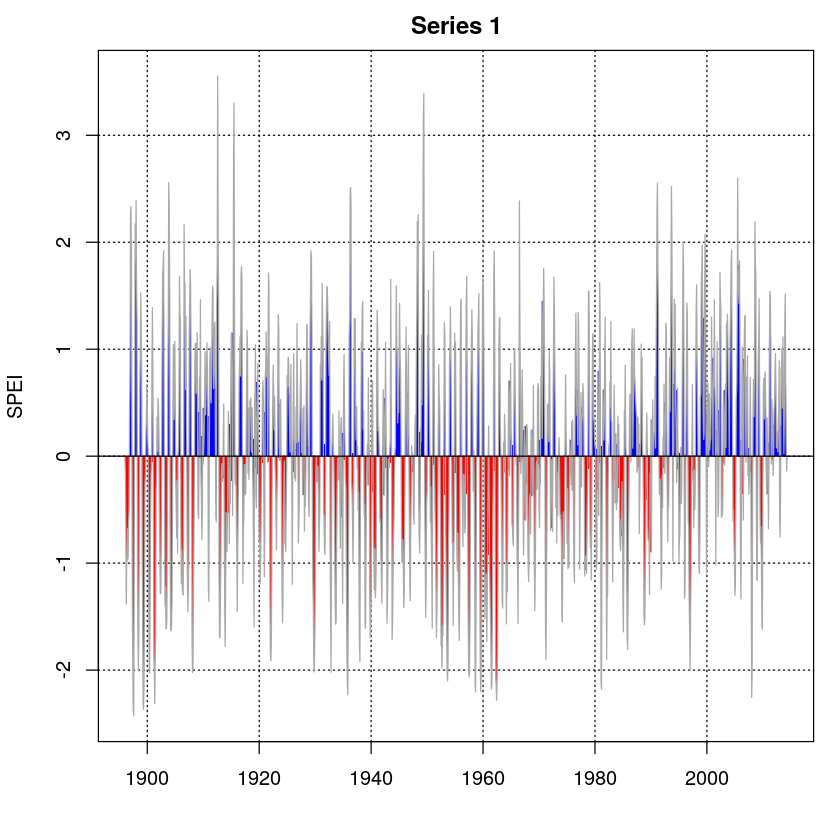

In [65]:
# Calculating spei using the R package described here: http://sac.csic.es/spei/tools.html
spei_3mo <- get_spei(cwdiff, int_per=3)

In [66]:
# Extract SPEI values into an xts object
spei_xts <- xts(as.vector(spei_3mo$fitted),  order.by=index(cwdiff))
colnames(spei_xts) <- c('spei3mo')
head(spei_xts)

              spei3mo
1895-11-30         NA
1896-02-29         NA
1896-03-31  1.1550937
1896-04-30 -0.1365257
1896-05-31 -0.6644630
1896-06-30 -1.3828918

## 6 month SPEI

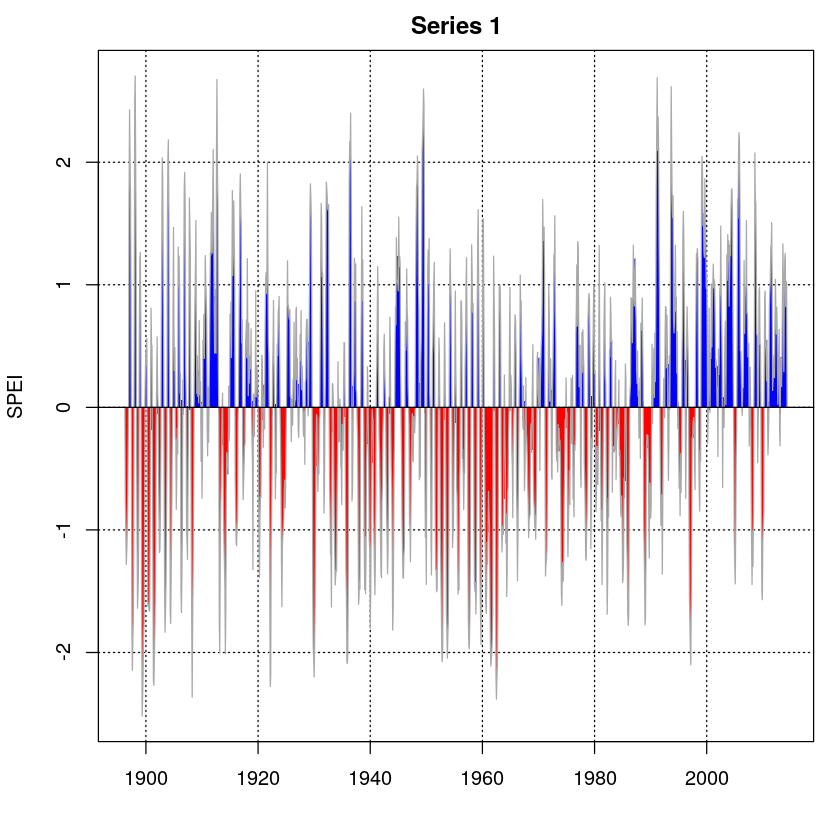

In [67]:
# Calculating spei using the R package described here: http://sac.csic.es/spei/tools.html
# By default this will fetch 6 month integrated SPEI
spei_6mo <- get_spei(cwdiff)

In [68]:
# Add to xts
spei_xts$spei6mo <- xts(as.vector(spei_6mo$fitted),  order.by=index(cwdiff))
head(spei_xts)

              spei3mo    spei6mo
1895-11-30         NA         NA
1896-02-29         NA         NA
1896-03-31  1.1550937         NA
1896-04-30 -0.1365257         NA
1896-05-31 -0.6644630         NA
1896-06-30 -1.3828918 -0.3326986

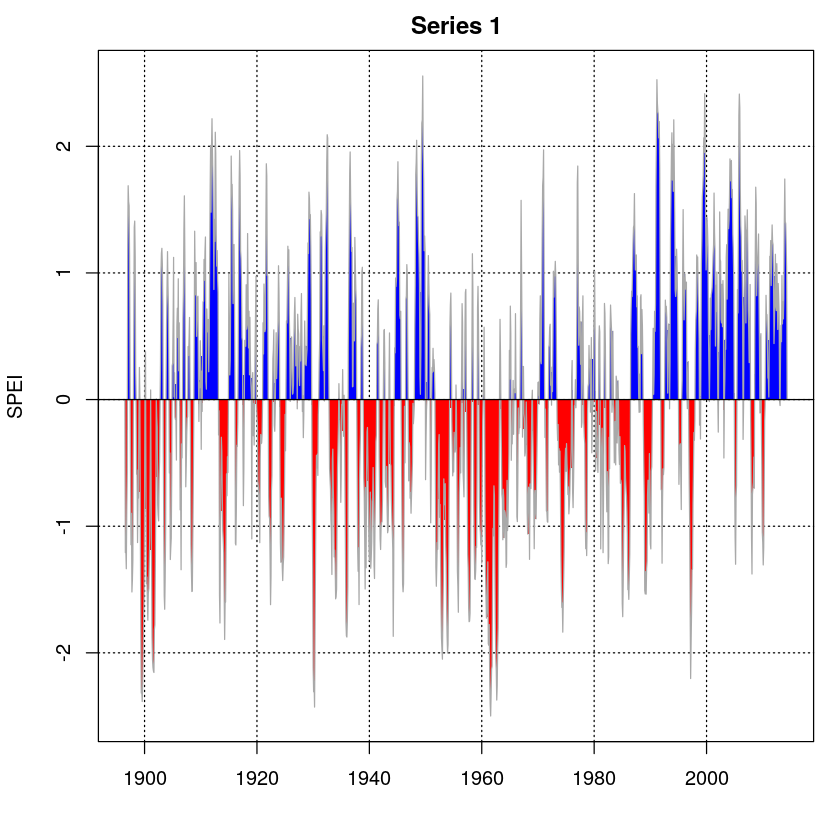

In [69]:
# Now get 9 month
spei_9mo <- get_spei(cwdiff, int_per=9)

In [70]:
# Add to xts
spei_xts$spei9mo <- xts(as.vector(spei_9mo$fitted),  order.by=index(cwdiff))
head(spei_xts)

              spei3mo    spei6mo spei9mo
1895-11-30         NA         NA      NA
1896-02-29         NA         NA      NA
1896-03-31  1.1550937         NA      NA
1896-04-30 -0.1365257         NA      NA
1896-05-31 -0.6644630         NA      NA
1896-06-30 -1.3828918 -0.3326986      NA

## 12 Month SPEI

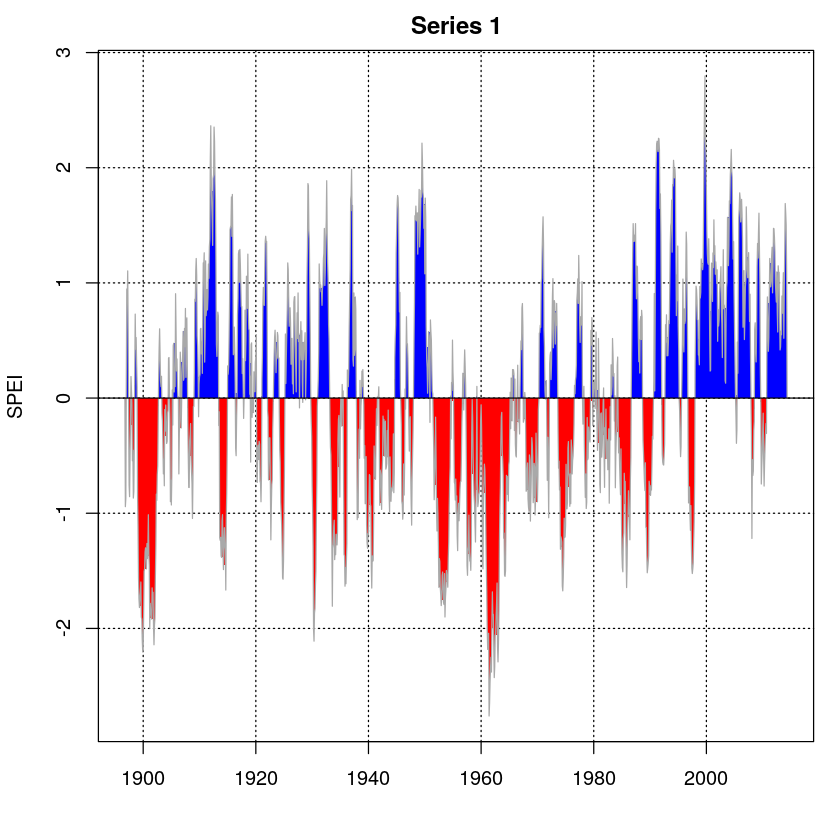

In [71]:
# Now get 1year
spei_12mo <- get_spei(cwdiff, int_per=12)

In [72]:
# Add to xts
spei_xts$spei12mo <- xts(as.vector(spei_12mo$fitted),  order.by=index(cwdiff))
head(spei_xts)

              spei3mo    spei6mo spei9mo spei12mo
1895-11-30         NA         NA      NA       NA
1896-02-29         NA         NA      NA       NA
1896-03-31  1.1550937         NA      NA       NA
1896-04-30 -0.1365257         NA      NA       NA
1896-05-31 -0.6644630         NA      NA       NA
1896-06-30 -1.3828918 -0.3326986      NA       NA

## Is there a significant trend?

In [56]:
library(forecast)

Loading required package: timeDate
This is forecast 7.3 




Call:
tslm(formula = spei_ts ~ trend)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.79615 -0.73923  0.04695  0.70235  2.62230 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.492e-01  5.185e-02  -6.734 2.39e-11 ***
trend        4.953e-04  6.362e-05   7.786 1.33e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9734 on 1409 degrees of freedom
Multiple R-squared:  0.04125,	Adjusted R-squared:  0.04057 
F-statistic: 60.62 on 1 and 1409 DF,  p-value: 1.333e-14



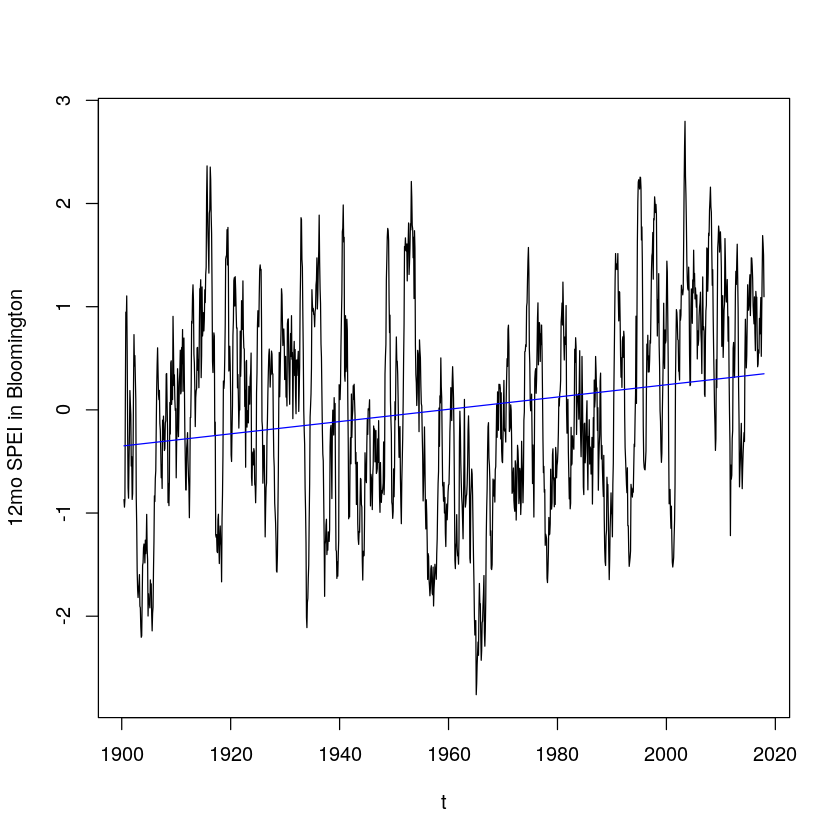

In [75]:
spei_ts <- ts(spei_xts$spei12mo[12:length(spei_xts$spei12mo)], frequency=12, start=c(1900, 6))
spei.fit <- tslm(spei_ts ~ trend)
plot(spei_ts, ylab="12mo SPEI in Bloomington", xlab="t")
lines(fitted(spei.fit), col='blue')
print(summary(spei.fit))
# Looks like it

## Coefficient of Variation

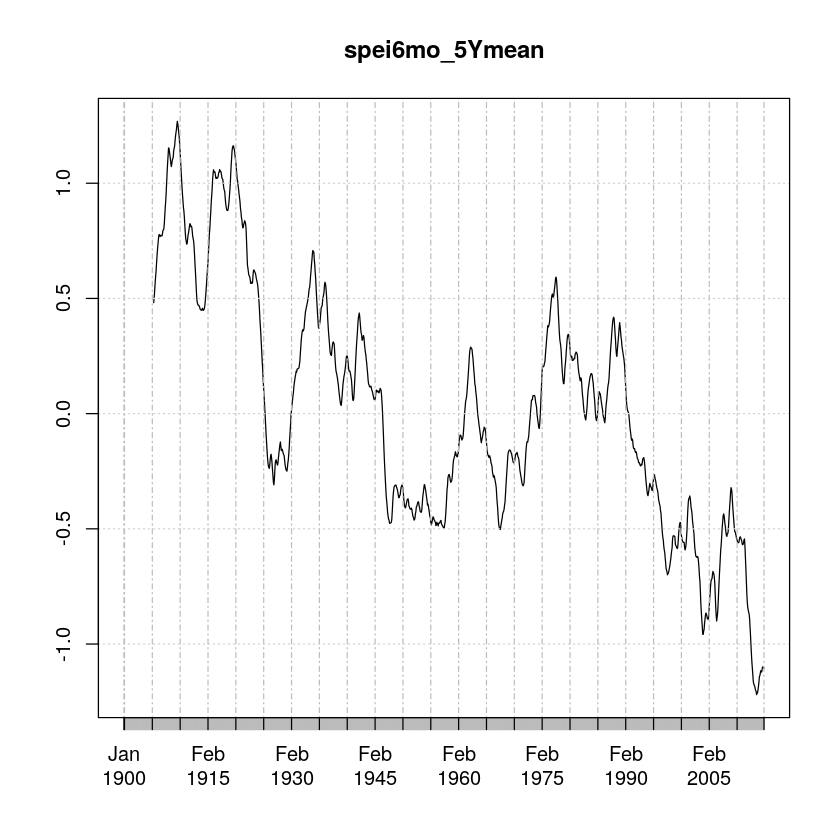

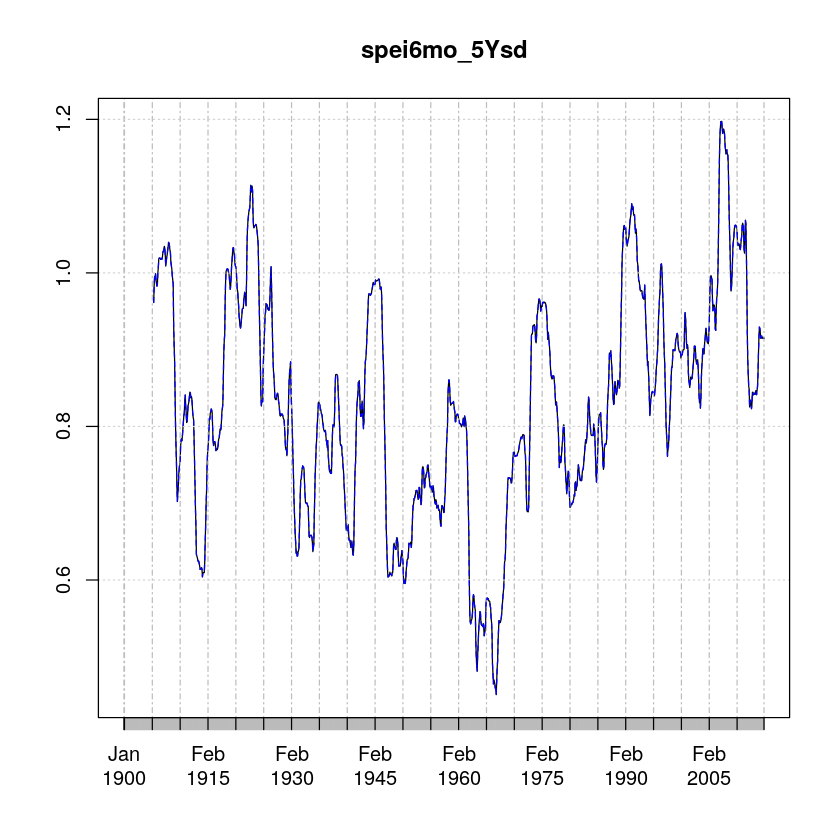

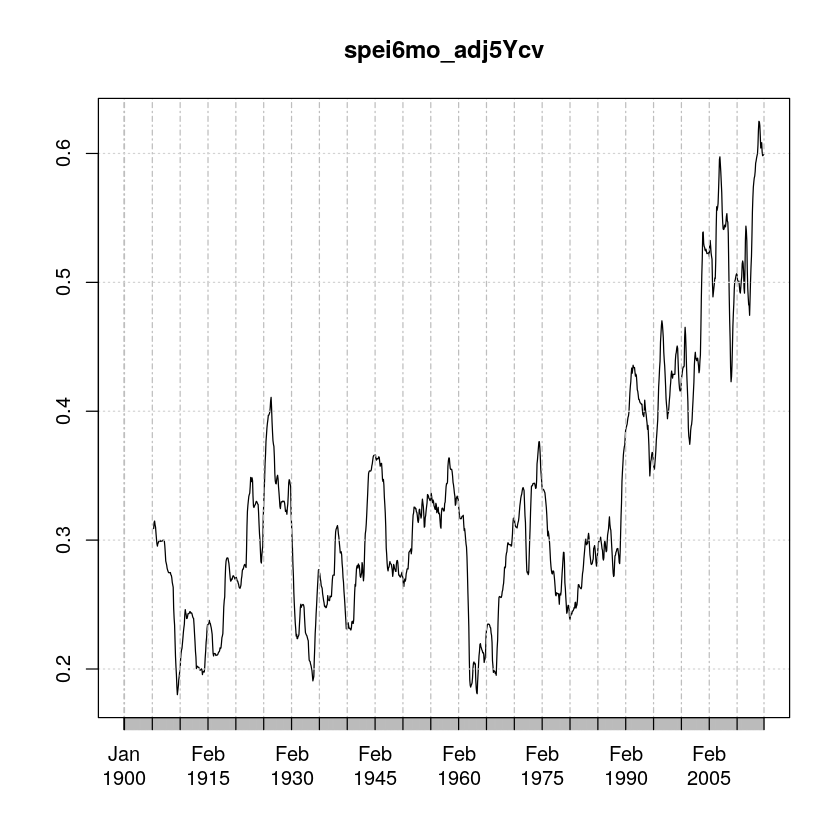


Call:
tslm(formula = cv_ts ~ trend)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.151231 -0.038422 -0.000428  0.041820  0.189765 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2.135e-01  3.767e-03   56.68   <2e-16 ***
trend       1.699e-04  4.954e-06   34.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06828 on 1314 degrees of freedom
Multiple R-squared:  0.4722,	Adjusted R-squared:  0.4718 
F-statistic:  1175 on 1 and 1314 DF,  p-value: < 2.2e-16



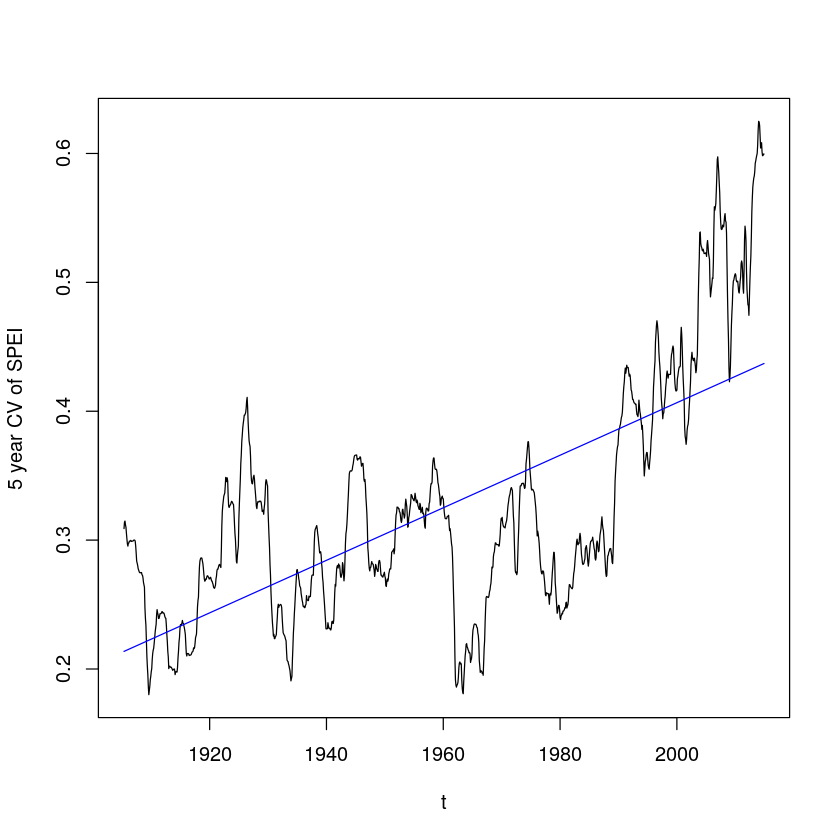

In [11]:
# 5 year rolling CV calculation
# Specify window width
wid <- 5*12
# Calculate 5 year mean SPEI
spei6mo_5Ymean <- rollapply(spei_xts$spei6mo, wid, mean, align='right')
# Calculate an adjusted spei (>0 for calculating CV) then get its 5Y mean
spei6mo_adj <- spei_xts$spei6mo - min(spei_xts$spei6mo, na.rm=TRUE)
spei6mo_adj5Ymean <- rollapply(spei6mo_adj, wid, mean, align='right')

# Standard dev
spei6mo_5Ysd <- rollapply(spei_xts$spei6mo, wid, sd, align='right')
# Standard deviation of adjusted data
spei6mo_adj5Ysd <- rollapply(spei6mo_adj, wid, sd, align='right')
# CV
spei6mo_adj5Ycv <- spei6mo_adj5Ysd/spei6mo_adj5Ymean

# Plot mean
plot(spei6mo_5Ymean)
# Plot sd and adjusted-data sd (they should be the same)
plot(spei6mo_5Ysd)
lines(spei6mo_adj5Ysd, col='blue', lty=2)
# Plot cv
plot(spei6mo_adj5Ycv)

# Look for a trend in CV and plot again
cv_ts <- ts(spei6mo_adj5Ycv[(wid+5):length(spei6mo_adj5Ycv)], frequency=12, start=c(1905, 5))
cv.fit <- tslm(cv_ts ~ trend)
plot(cv_ts, ylab="5 year CV of SPEI", xlab="t")
lines(fitted(cv.fit), col='blue')
print(summary(cv.fit))

# Add to xts
spei_xts$spei6mo_5Ymean <- spei6mo_5Ymean
spei_xts$spei6mo_adj5Ymean <- spei6mo_adj5Ymean
spei_xts$spei6mo_5Ysd <- spei6mo_5Ysd
spei_xts$spei6mo_adj5Ysd <- spei6mo_adj5Ysd
spei_xts$spei6mo_adj5Ycv <- spei6mo_adj5Ycv

In [73]:
head(spei_xts)
# Write data
outfile <- 'bloomington_1896_spei'
write.zoo(spei_xts, file = paste('output_data/Sev_SPEI/', outfile, '.csv', sep=''),
          index.name = "Date", sep=',', row.names = FALSE, col.names=TRUE)

              spei3mo    spei6mo spei9mo spei12mo
1895-11-30         NA         NA      NA       NA
1896-02-29         NA         NA      NA       NA
1896-03-31  1.1550937         NA      NA       NA
1896-04-30 -0.1365257         NA      NA       NA
1896-05-31 -0.6644630         NA      NA       NA
1896-06-30 -1.3828918 -0.3326986      NA       NA